# Group4 AML Challenge 1 Notebook

General thoughts: (Thoughts that are not yet assigned to a section)
- Model validation:
    - Dataset is probably too large for k-fold-cross-validation (Philipp)
    - We should put some regions only in the validation set and not the training set to have a good indicator on generalization performance. (Philipp)

- Performance:
    - We can quickly try out models with a small proxy subset (Philipp)
- Other:
    - We should balance the longitudes in terms of number samples


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/elevation-files/elevation_test.csv
/kaggle/input/elevation-files/elevation_train.csv
/kaggle/input/eurecom-aml-2022-challenge-1/example_preds.csv
/kaggle/input/eurecom-aml-2022-challenge-1/public/train.csv
/kaggle/input/eurecom-aml-2022-challenge-1/public/test_feat.csv


In [2]:
# Load data
df = pd.read_csv('../input/eurecom-aml-2022-challenge-1/public/train.csv',low_memory = True, dtype='float32')

In [3]:
df_test = pd.read_csv('../input/eurecom-aml-2022-challenge-1/public/test_feat.csv',low_memory = True, dtype='float32')

In [4]:
# Create smaller proxy subsets 'df_small_[magnitude]' with 10^magnitude random samples
for mag in [4, 5]:
    name = f'df_small_{mag}'
    globals()[name] = df.sample(n=10**mag, random_state=1, ignore_index=True)

# Data analysis
The purpose of the section is to explore the data:
- Get insight into the data
- Find potential problems for models
- Find biases in the data

TODOs:
- Do we have outliers and in which features?
- How many 'null' values are there and in which features?

Given description:\
"\
In this challenge, you are free (and encouraged) to explore in depth the data you have, you can run simple queries on the data, perform exploration and compute statistics.

**NOTE**: finding the right question to ask is difficult! Don't be afraid to complement your analysis with your own questions. This can give you extra points!

**NOTE 2**: the presentation quality is critical in any business-oriented data analysis. Take time to create few but informative plots, rather than endless tables!\
"

### General Properties of the Data
Motivation: Obvious

Results:
- ...

In [5]:
# df.describe() # takes a long time

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


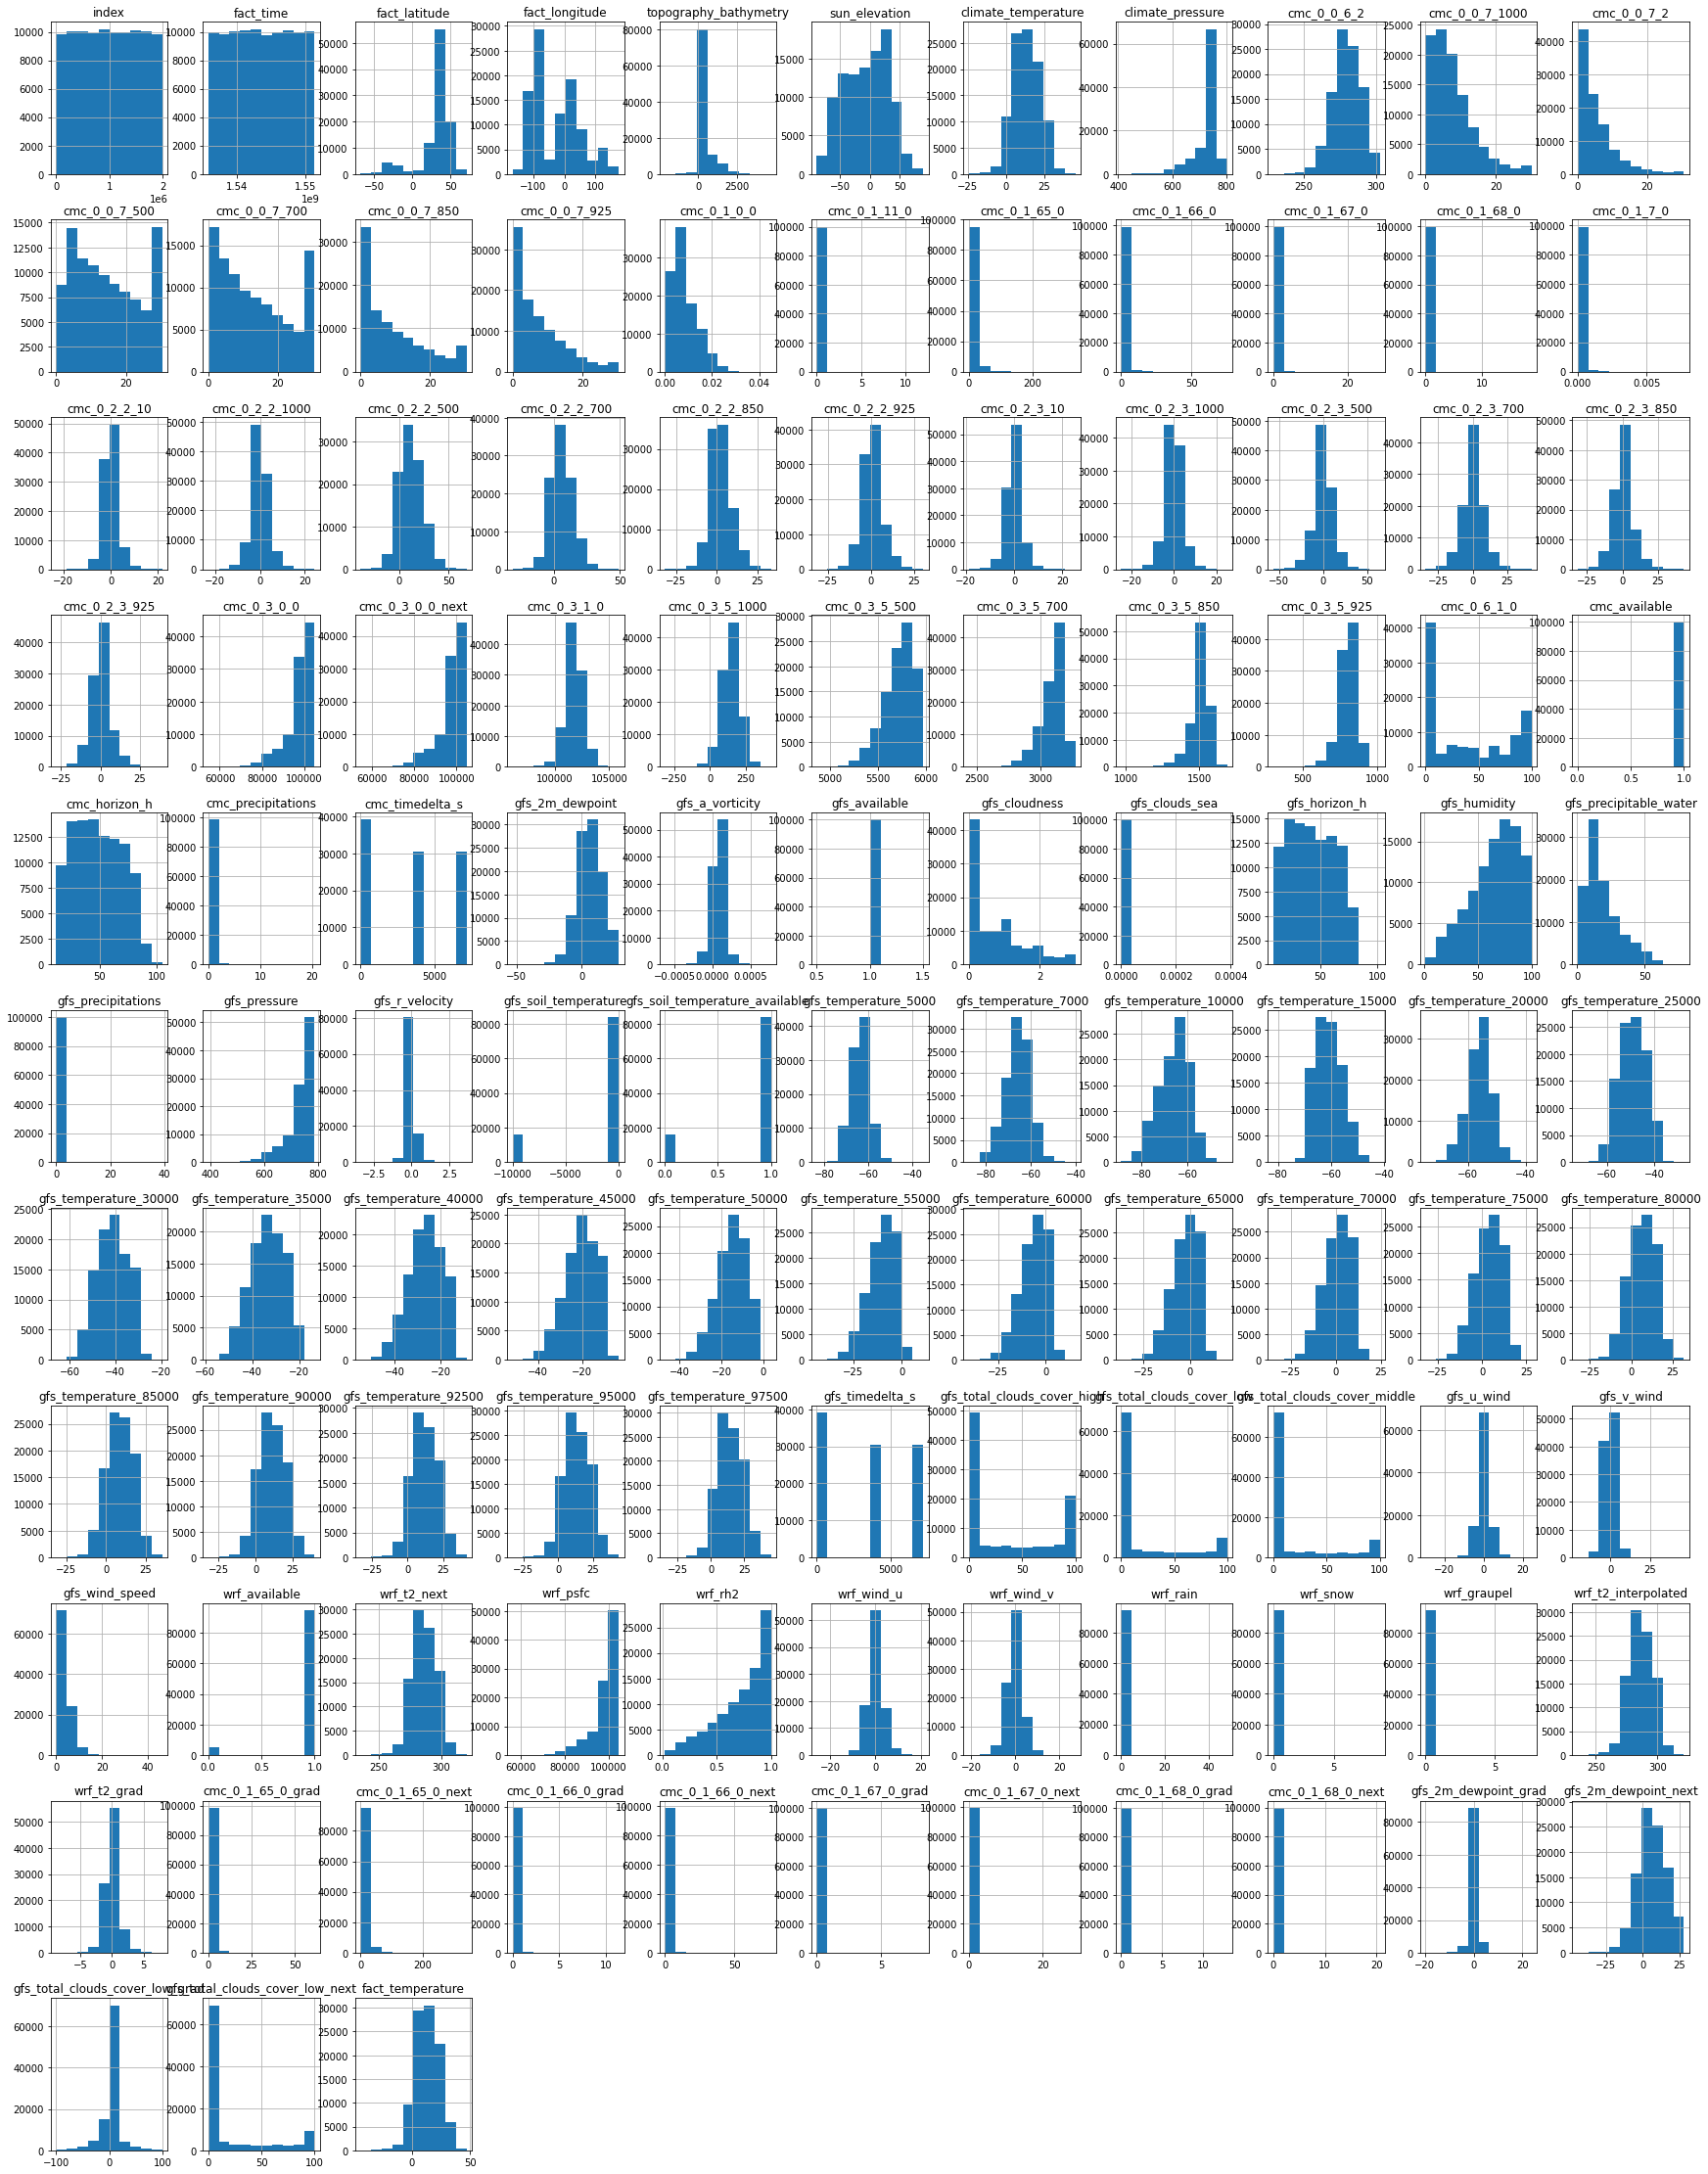

In [6]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (30,40))
ax = fig.gca()
df_small_5.hist(ax = ax)
pass

### Analyse NaN

In [7]:

# Create a dataframe that includes the number of data points for each location
nan_df = df[df.isnull().any(axis=1)]
nan_location_count = nan_df.groupby(['fact_latitude', 'fact_longitude']).size()
# Convert from series to dataframe and rename column to 'count'
nan_location_count = nan_location_count.reset_index().rename({0:'count'}, axis=1)
# Library reference for this code: https://plotly.com/python/mapbox-layers/
import plotly.express as px

fig = px.scatter_mapbox(nan_location_count, lat="fact_latitude", lon="fact_longitude", hover_name='count',
                        color='count', hover_data=["fact_latitude", "fact_longitude"],
                        color_discrete_sequence=["fuchsia"], zoom=1, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Plots Between fact_temp and other features 
Motivation : Make simple ploting functions to observe how our target feature (fact_temp) evolves wrt other features

**functions**:  
1.      **plot_tempeturs_in_function_of(column, df, color, label):**
            Does scatter plots between the temp and any other feature.  
2.      **plot_with_longitudes_steps(longitude_step, df, column):**
            Iterats trough a df making plots for several longitudes segments. longitude_step indicates the size of each segments ie the numbers of plots done 
        
Results: 
>        some features like cloud coverage give very noisy plots that show little corelation with fact_temp, whereas others like climate_temperature show easy to follow tendencies.

> An idea could be to try and train simple perceptrons to define upper and lower bounds within which we can make more precise regressions (dont know if that makes good sense)

In [8]:
df_small_4.isnull().sum().sum()

5398

In [9]:
import matplotlib.pyplot as plt

def plot_tempeturs_in_function_of(column, df, color, label):
    df_sort = df.sort_values(column)
    plt.figure(figsize=(8, 6), dpi=80)
    Y = []
    X = []
    for index, row in df.iterrows():
        Y.append(np.float64(row.fact_temperature))
        X.append(np.float64(row[column]))
    # plot point clouds 
    plt.scatter(X,Y,c = color, label = label)
    plt.legend()
    plt.title(f"tempeturs_in_function_of_{str(column)}")
    plt.xlabel(column)
    plt.ylabel("fact_temperature")

In [10]:
def plot_with_longitudes_steps(longitude_step, df, column):
    df.sort_values('fact_longitude')
    color = iter(plt.cm.rainbow(np.linspace(0, 1, longitude_step)))
    longitude_start = -180
    plt.figure(figsize=(8, 6), dpi=80)
    Y = []
    X = []
    while(longitude_start < 180):
        df_longitude_step = df.where(df.fact_longitude <= longitude_start + longitude_step)
        df_longitude_step = df_longitude_step.where(df.fact_longitude >= longitude_start)
        c = next(color)
        plot_tempeturs_in_function_of(column, df_longitude_step, c, f'{str(longitude_start)}/{str(longitude_start + longitude_step)}')
        longitude_start += longitude_step

In [11]:
df_count_nulls = df.isnull().sum()
df_disp_null_count = df_count_nulls.loc[(df_count_nulls != 0)]
df_disp_null_count

cmc_0_0_6_2              1801
cmc_0_0_7_1000           1801
cmc_0_0_7_2              1801
cmc_0_0_7_500            1801
cmc_0_0_7_700            1801
cmc_0_0_7_850            1801
cmc_0_0_7_925            1801
cmc_0_1_0_0              1801
cmc_0_1_11_0             1801
cmc_0_1_65_0             1801
cmc_0_1_66_0             1801
cmc_0_1_67_0             1801
cmc_0_1_68_0             1801
cmc_0_1_7_0              1801
cmc_0_2_2_10             1801
cmc_0_2_2_1000           1801
cmc_0_2_2_500            1801
cmc_0_2_2_700            1801
cmc_0_2_2_850            1801
cmc_0_2_2_925            1801
cmc_0_2_3_10             1801
cmc_0_2_3_1000           1801
cmc_0_2_3_500            1801
cmc_0_2_3_700            1801
cmc_0_2_3_850            1801
cmc_0_2_3_925            1801
cmc_0_3_0_0              1801
cmc_0_3_0_0_next         1801
cmc_0_3_1_0              1801
cmc_0_3_5_1000           1801
cmc_0_3_5_500            1801
cmc_0_3_5_700            1801
cmc_0_3_5_850            1801
cmc_0_3_5_

In [12]:
#plot_with_longitudes_steps(30, df_small, 'climate_temperature')
#plot_with_longitudes_steps(30,df_small_4,'wrf_t2_next')
#plot_tempeturs_in_function_of('wrf_t2_next', df_small_4, 'r', '-180/180')
#plot_tempeturs_in_function_of('climate_temperature', df_small, 'r', '-180/180')
#plot_tempeturs_in_function_of('gfs_cloudness', df_small, 'r', '-180/180')
#plot_tempeturs_in_function_of('gfs_humidity', df_small, 'r', '-180/180')
#plot_tempeturs_in_function_of('gfs_precipitations', df_small, 'r', '-180/180')

### Correlation Between fact_temperature and other features
Motivation: See how features correlate with target feature\
Results:
- Features with the strongest correlation to the target/fact_temperature are:
    1. wrf_t2_interpolated:      0.963
    2. wrf_t2_next:              0.958
    3. gfs_temperature_97500:    0.874
    4. gfs_temperature_95000:    0.863

In [13]:
corr_small_5 = df_small_5.corr(method ='pearson')
best_features = list(corr_small_5['fact_temperature'].sort_values(ascending=False).head(60).index)
best_features

['fact_temperature',
 'wrf_t2_interpolated',
 'wrf_t2_next',
 'gfs_temperature_97500',
 'gfs_temperature_95000',
 'climate_temperature',
 'gfs_temperature_92500',
 'gfs_temperature_90000',
 'gfs_temperature_85000',
 'gfs_temperature_80000',
 'cmc_0_0_6_2',
 'gfs_temperature_75000',
 'gfs_temperature_70000',
 'gfs_temperature_65000',
 'cmc_0_1_0_0',
 'gfs_temperature_60000',
 'gfs_temperature_55000',
 'gfs_temperature_50000',
 'gfs_temperature_45000',
 'gfs_temperature_40000',
 'gfs_2m_dewpoint_next',
 'gfs_2m_dewpoint',
 'gfs_temperature_35000',
 'gfs_temperature_30000',
 'cmc_0_3_5_500',
 'gfs_precipitable_water',
 'gfs_temperature_25000',
 'cmc_0_3_5_700',
 'cmc_0_0_7_2',
 'sun_elevation',
 'cmc_0_3_5_850',
 'gfs_temperature_20000',
 'cmc_0_0_7_1000',
 'fact_longitude',
 'climate_pressure',
 'cmc_0_3_0_0',
 'gfs_pressure',
 'cmc_0_3_0_0_next',
 'cmc_0_0_7_500',
 'cmc_0_2_3_500',
 'cmc_0_2_3_700',
 'wrf_psfc',
 'cmc_0_0_7_925',
 'cmc_0_2_3_850',
 'cmc_0_2_3_1000',
 'cmc_0_2_3_925',
 '

### Analyse temperature distribution
Motivation: Find representation of temperature ranges as well es outliers
Results:
- Majority of our temperature points are between 0 and 30 C,
- Few strange outliers. Is t = 60 C real??


**Note:** Consider plotting the temperatures during the day and night independently, e.g., 11:00-14:00 and 2:00-6:00 (Philipp)


<AxesSubplot:>

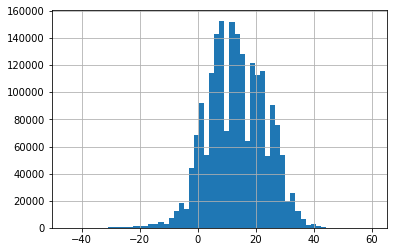

In [14]:
temps = df['fact_temperature']
temps.hist(bins=60)

### Show data point density
Motivation: See how dense the samples are in the different areas in the training and test data. Also see how many data points we have in the different regions.

Results:
- most data points in nothern hemisphere
- few data points near equator and towards the poles

In [15]:
# Create a dataframe that includes the number of data points for each location
df_location_count = df.groupby(['fact_latitude', 'fact_longitude']).size()
# Convert from series to dataframe and rename column to 'count'
df_location_count = df_location_count.to_frame().reset_index().rename({0:'count'}, axis=1)

In [16]:
import plotly.express as px
fig = px.density_mapbox(df_location_count, lat='fact_latitude', lon='fact_longitude', z='count', radius=5,
                        center=dict(lat=0, lon=180), zoom=0, title = "Heatmap <br><sup>Heatmap of data point density (does not take number of data points per location into account)</sup>",
                        mapbox_style="stamen-terrain")
fig.show()

### Show data point count per location
Motivation: See how many data points we have in the different measure locations

Results:
- Total of 8053 different locations
- Most locations have below 20 data points
- Locations in the US have lots of data points per location (around 600 for most)

count    5628.000000
mean      354.224236
std       291.595255
min         1.000000
25%       103.000000
50%       251.500000
75%       556.000000
max      1107.000000
Name: count, dtype: float64

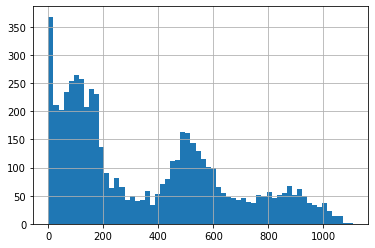

In [17]:
df_location_count['count'].hist(bins=60)
df_location_count['count'].describe()

In [18]:
# Library reference for this code: https://plotly.com/python/mapbox-layers/
import plotly.express as px

fig = px.scatter_mapbox(df_location_count, lat="fact_latitude", lon="fact_longitude", hover_name='count',
                        color='count', hover_data=["fact_latitude", "fact_longitude"],
                        color_discrete_sequence=["fuchsia"], zoom=1, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

###  Latitude Data point distribution
Motivation: See which longitudes are over and under represented

Results:
- Most data points are between the latitude 40 - 60

TODOs:
- Integrate test data

<AxesSubplot:>

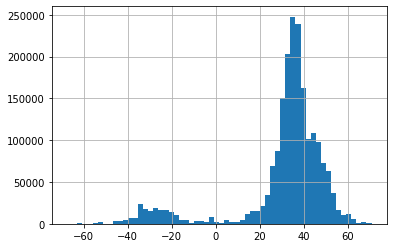

In [19]:
df['fact_latitude'].hist(bins=60)

# Data Pre-processing/Feature Engineering
In this section we process the data by doing for example the following things:
-    Normalising and standardising the given data;
-    Removing outliers;
-    Carrying out feature selection, possibly using metrics derived from information theory;
-    Handling missing information in the dataset;
-    Augmenting the dataset with external information;
-    Combining existing features.

Ideas:
- [x] Hour of the day to distinguish between day and night
- [ ] Temperature forecast for closest (& above & below) forecast height
- [ ] Interpolated between closest two temperature forecast heights depending on distance

### Feature: Elevation

In [20]:
def add_elevation(df_, filename='../input/elevation-files/elevation_train.csv'):
    df_height = pd.read_csv(filename, index_col='Unnamed: 0')
    df_['elevation'] = df_height
add_elevation(df)
add_elevation(df_test, filename='../input/elevation-files/elevation_test.csv')

In [21]:
def get_elevation(df_, name='train'):
    !pip install SRTM.py
    import srtm
    from tqdm import tqdm
    location_count = df_.groupby(['fact_latitude', 'fact_longitude'])
    elevation_data = srtm.get_data(local_cache_dir="/kaggle/working/geo_cache", srtm1=False, srtm3=True)
    for group_id in tqdm(location_count.groups):
        height = elevation_data.get_elevation(*group_id, approximate=False)
        df_.loc[location_count.groups[group_id], 'elevation'] = height
    df_['elevation'].to_csv(f'elevation_{name}.csv')

In [22]:
# get_elevation(df_test, name='test')

### Feature: Approximate Hour of the Day: 'approx_hour'
Motivation: Help classifier to distinguish between day and night

Not exact hour because then we would need take look up the time zone of every location. 
Instead, time zone offset is approximated based on the longitude.\
Greenwhich is longitude 0 and time zone UTC -> +-180 longitude is 12 hours of time offset with linear interpolation in between.

In [23]:
def add_hour(df_):
    date_time = pd.to_datetime(df_['fact_time'], unit='s')
    hour = date_time.dt.hour
    minute = date_time.dt.minute
    # Unix time does not take the time zone into account -> add offset based on longitude
    longitude_time_offset = (df_['fact_longitude'] * 12 / 180)

    df_['approx_hour'] = (hour + minute/60 + longitude_time_offset)%24
    return df_

In [24]:
def add_hour_floor(df_):
    date_time = pd.to_datetime(df_['fact_time'], unit='s')
    hour = date_time.dt.hour
    minute = date_time.dt.minute
    # Unix time does not take the time zone into account -> add offset based on longitude
    longitude_time_offset = (df_['fact_longitude'] * 12 / 180)
    df_['floor_hour'] = (hour + minute/60 + longitude_time_offset)%24
    df_['floor_hour'] = df_['floor_hour'].apply(np.floor).astype('int8')
    return df_

def add_month(df_):
    date_time = pd.to_datetime(df_['fact_time'], unit='s')
    month = date_time.dt.month
    # Unix time does not take the time zone into account -> add offset based on longitude
    df_['month'] = month
    return df_

from sklearn.preprocessing import OneHotEncoder

def OHE_df(df_, feature):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(df_[[feature]]).toarray())
    encoder_df.columns = encoder_df.columns.astype('str')
    encoder_df.columns = [feature +' : ' + col_name for col_name in encoder_df.columns]
    final_df = pd.concat([df_, encoder_df], axis=1, join='inner')
    final_df = final_df.drop([feature], axis = 1)
    return final_df

### Preprocessing

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

class DataProcessor:
    def __init__(self, config_:dict):
        self.c = config_
        self.mean_imputer = None
        self.pca = None
        self.norm_mean = None
        self.norm_std = None
        self.min_max_scaler = None
        self.robust_scaler = None
        self.features = self.c['white_features']

    def fit_transform(self, df_):
        """For training data"""
        # Feature filter
        if self.c['feature_white_list']:
            df_ = df_[self.features]
        
        df_ = df_[df_['fact_temperature'] < 42.0]
        df_ = df_[df_['fact_temperature'] > -30.0]
        #df_ = df_[df_['fact_latitude'] < 40]
        # df_ = df_[df_['fact_latitude'] > -40.0]
        

        # Drop NaN Samples
        if self.c['drop_nan_samples']:
            len_before = len(df_)
            df_ = df_.dropna()
            print(f"Dropped {len_before - len(df_)} NaN samples")

        
        # Fill NaN
        if self.c['fill_nan']:
            df_.fillna(self.c['fill_nan_value'], inplace=True)

        for feat in self.c['power2_features']:
            df_[f'{feat}_p2'] = np.power((df_[feat]),2)

        X_, y_ = df_.drop(['fact_temperature'], axis=1), df_['fact_temperature']

        
        # Impute with mean
        if self.c['impute_with_mean']:
            cols = X_.columns
            indices = X_.index
            self.mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            self.mean_imputer.fit(X_)
            X_ = pd.DataFrame(self.mean_imputer.transform(X_), columns=cols, index=indices)
        
        # Normalize
        if self.c['normalize']:
            X_ = self.normalize(X_, fit=True)
        
        if self.c['c_feat_hour']:
            X_ = add_hour(X_)
        
        if self.c['one_hot_encode']:
            X_ = add_floor_hour(X_)
            X_ = OHE_df(X_, 'floor_hour')
            
        # PCA
        if self.c['pca']:
            self.pca = PCA(n_components = self.c['pca_components'])
            principal_components = self.pca.fit_transform(X_)
            principal_df = pd.DataFrame(data=principal_components)
            X_ = X_.join(principal_df)
            Z_ = X_.join(y_)
            len_before = len(Z_)
            Z_.dropna(inplace=True)
            print(f"Dropped {len_before - len(Z_)} training NaN examples after PCA")
            
            X_, y_ = Z_.iloc[:, :-1], Z_.iloc[:, -1]
        feature_names = X_.columns
        X_, y_ = X_.to_numpy(), y_.to_numpy()

        if self.c['min_max_scaler']:
            self.min_max_scaler = MinMaxScaler()
            X_ = self.min_max_scaler.fit_transform(X_)
        if self.c['standard_scaler']:
            self.standard = StandardScaler()
            X_ = self.standard.fit_transform(X_)
        if self.c['robust_scaler']:
            self.robust = RobustScaler()
            X_ = self.robust.fit_transform(X_)
        
        return X_, y_, feature_names

    def transform(self, df_, target=True):
        """For evaluation data"""
        # Feature Filter: Keep only specified features. Ignore target column if specified.
        if self.c['feature_white_list']:
            df_ = df_[self.features] if target else df_[[x for x in self.features if x != "fact_temperature"]]
        
        # drop_high_nan(df_, threshold=self.c['drop_high_nan_cols_thres'])
        
            
        # Drop NaN Samples
        if self.c['drop_nan_samples']:
            df_.dropna(inplace=True)

        # Fill NaN
        if self.c['fill_nan']:
            df_.fillna(self.c['fill_nan_value'], inplace=True)
        
        for feat in self.c['power2_features']:
            df_[f'{feat}_p2'] = np.power((df_[feat]),2)

        if target:
            X_, y_ = df_.drop(['fact_temperature'], axis=1), df_['fact_temperature']
        else:
            X_, y_ = df_, None

        # Impute with mean
        if self.c['impute_with_mean']:
            cols = X_.columns
            indices = X_.index
            X_ = pd.DataFrame(self.mean_imputer.transform(X_), columns=cols, index=indices)

        # Normalize
        if self.c['normalize']:
            X_ = self.normalize(X_, fit=False)
            
        if self.c['c_feat_hour']:
            X_ = add_hour(X_)
            
        if self.c['one_hot_encode']:
            X_ = add_floor_hour(X_)
            X_ = OHE_df(X_, 'floor_hour')
            
        # PCA
        if self.c['pca']:
            principal_components = self.pca.transform(X_)
            principal_df = pd.DataFrame(data=principal_components)
            X_ = X_.join(principal_df)
            # X_ = principal_df # ATTENTION
            if target:
                Z_ = X_.join(y_)
                len_before = len(Z_)
                Z_.dropna(inplace=True)
                
                print(f"Transform: Dropped {len_before - len(Z_)} training NaN examples after PCA")
            
                X_, y_ = Z_.drop(['fact_temperature'], axis=1), Z_['fact_temperature']
            else:
                print(f"Test set NaN: {np.isnan(X_).sum().sum()}")
        X_ = X_.to_numpy()
        y_ = y_.to_numpy() if target else y_

        if self.c['min_max_scaler']:
            X_ = self.min_max_scaler.transform(X_)
        
        if self.c['standard_scaler']:
            X_ = self.standard.transform(X_)
            
        if self.c['robust_scaler']:
            X_ = self.robust.transform(X_)

        return X_, y_
    
        
    
    def normalize(self, df_, fit=True):
        if fit:
            self.norm_mean = df_.mean()
            self.norm_std = df_.std()
        return (df_-self.norm_mean)/self.norm_std

In [26]:
def identify_covariate_shift(df_, df_test_, threshold=0.7):
    # importing libraries
    import numpy as np
    import pandas as pd
    from pandas import Series, DataFrame
    import os
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.preprocessing import LabelEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.model_selection import train_test_split

    # df_train, df_val = train_test_split(df, test_size=0.1, random_state=21)
    X_train, y_train = df.drop(['fact_temperature'], axis=1), df_['fact_temperature']
    X_test = df_test_

    X_train['origin'] = 0
    X_test['origin'] = 1
    train_cols = X_train.columns
    test_cols = X_test.columns
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean.fit(X_train)
    X_train = imp_mean.transform(X_train)
    X_test = imp_mean.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=train_cols)
    X_test = pd.DataFrame(X_test, columns=test_cols)

    training = X_train.sample(10000, random_state=12)
    testing = X_test.sample(10000, random_state=11)

    ## combining random samples
    combi = training.append(testing)
    y = combi['origin']
    combi.drop('origin',axis=1,inplace=True)

    ## modelling
    model = RandomForestClassifier(n_estimators = 50,n_jobs=-1, max_depth = 5,min_samples_leaf = 5, verbose=False)
    cov_shift_dict = {}
    for i in combi.columns:
        score = cross_val_score(model,pd.DataFrame(combi[i]),y,cv=2,scoring='roc_auc')
        cov_shift_dict[i] = np.mean(score)
        # print(i, ": ",np.mean(score))
        
    keep_features_list = []
    #for name, value in cov_shift_dict.items():
    #    if value<threshold and name or name in best_features[:10]:
    #        keep_features_list.append(name)
    #    else:
    #        print(f'Dropped: {name}')
    df_test_ = df_test.drop(['origin'], axis=1)
    df_covariance = pd.Series(cov_shift_dict).drop('index')
    ax = df_covariance.plot.hist(bins=18)
    ax.set_xlabel('Estimated Covariant Shift')
    ax.set_ylabel('Number of Features')
    fig = ax.get_figure()
    fig.savefig('cov_shift.png')
    return keep_features_list, cov_shift_dict, df_covariance
#keep_features_list, _, df_covariance = identify_covariate_shift(df, df_test)
# df_test = df_test.drop(['origin'], axis=1)

# Model Selection and Submission



### Configuration

In [27]:
config = {
    # Data processing
    'feature_white_list': False,
    'validation_ratio': 0.05,
    'power2_features': ['climate_temperature', 'gfs_soil_temperature', 'wrf_t2_interpolated', 'wrf_t2_next'],
    #'white_features': ['fact_temperature', 'gfs_soil_temperature', 'wrf_t2_interpolated','wrf_t2_next', 'fact_time', 'fact_latitude', 'gfs_temperature_97500', 'gfs_temperature_95000', 'climate_temperature','gfs_temperature_92500', 'gfs_temperature_90000','gfs_temperature_85000', 'gfs_temperature_80000', 'cmc_0_0_6_2','gfs_temperature_75000', 'gfs_temperature_70000','gfs_temperature_65000', 'cmc_0_1_0_0', 'gfs_temperature_60000','gfs_temperature_55000', 'gfs_temperature_50000','gfs_temperature_45000', 'gfs_temperature_40000','gfs_2m_dewpoint_next', 'gfs_2m_dewpoint', 'gfs_temperature_35000','gfs_temperature_30000', 'cmc_0_3_5_500', 'gfs_precipitable_water','gfs_temperature_25000', 'cmc_0_3_5_700', 'cmc_0_0_7_2','sun_elevation', 'cmc_0_3_5_850', 'gfs_temperature_20000','cmc_0_0_7_1000', 'fact_longitude', 'climate_pressure', 'cmc_0_3_0_0','gfs_pressure', 'cmc_0_3_0_0_next', 'cmc_0_0_7_500', 'cmc_0_2_3_500'],
    #'white_features': ['fact_time', 'topography_bathymetry', 'sun_elevation', 'climate_pressure', 'cmc_0_0_7_1000', 'cmc_0_0_7_2', 'cmc_0_0_7_500', 'cmc_0_0_7_700', 'cmc_0_0_7_850', 'cmc_0_0_7_925', 'cmc_0_1_11_0', 'cmc_0_1_65_0', 'cmc_0_1_66_0', 'cmc_0_1_67_0', 'cmc_0_1_68_0', 'cmc_0_1_7_0', 'cmc_0_2_2_10', 'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700', 'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000', 'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925', 'cmc_0_3_0_0', 'cmc_0_3_0_0_next', 'cmc_0_3_1_0', 'cmc_0_3_5_1000', 'cmc_0_3_5_700', 'cmc_0_3_5_850', 'cmc_0_3_5_925', 'cmc_0_6_1_0', 'cmc_available', 'cmc_horizon_h', 'cmc_precipitations', 'cmc_timedelta_s', 'gfs_a_vorticity', 'gfs_available', 'gfs_cloudness', 'gfs_clouds_sea', 'gfs_horizon_h', 'gfs_humidity', 'gfs_precipitations', 'gfs_pressure', 'gfs_r_velocity', 'gfs_soil_temperature', 'gfs_soil_temperature_available', 'gfs_temperature_5000', 'gfs_temperature_20000', 'gfs_timedelta_s', 'gfs_total_clouds_cover_high', 'gfs_total_clouds_cover_low', 'gfs_total_clouds_cover_middle', 'gfs_u_wind', 'gfs_v_wind', 'gfs_wind_speed', 'wrf_available', 'wrf_psfc', 'wrf_rh2', 'wrf_wind_u', 'wrf_wind_v', 'wrf_rain', 'wrf_snow', 'wrf_graupel', 'wrf_t2_grad', 'cmc_0_1_65_0_grad', 'cmc_0_1_65_0_next', 'cmc_0_1_66_0_grad', 'cmc_0_1_66_0_next', 'cmc_0_1_67_0_grad', 'cmc_0_1_67_0_next', 'cmc_0_1_68_0_grad', 'cmc_0_1_68_0_next', 'gfs_2m_dewpoint_grad', 'gfs_total_clouds_cover_low_grad', 'gfs_total_clouds_cover_low_next'],
    # All features except those with high covariate shift
    'white_features': ['fact_temperature', 'fact_longitude', 'fact_time', 'topography_bathymetry', 'sun_elevation', 'climate_temperature', 'climate_pressure', 'cmc_0_0_7_1000', 'cmc_0_0_7_2', 'cmc_0_0_7_500', 'cmc_0_0_7_700', 'cmc_0_0_7_850', 'cmc_0_0_7_925', 'cmc_0_1_11_0', 'cmc_0_1_65_0', 'cmc_0_1_66_0', 'cmc_0_1_67_0', 'cmc_0_1_68_0', 'cmc_0_1_7_0', 'cmc_0_2_2_10', 'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700', 'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000', 'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925', 'cmc_0_3_0_0', 'cmc_0_3_0_0_next', 'cmc_0_3_1_0', 'cmc_0_3_5_1000', 'cmc_0_3_5_700', 'cmc_0_3_5_850', 'cmc_0_3_5_925', 'cmc_0_6_1_0', 'cmc_available', 'cmc_horizon_h', 'cmc_precipitations', 'cmc_timedelta_s', 'gfs_a_vorticity', 'gfs_available', 'gfs_cloudness', 'gfs_clouds_sea', 'gfs_horizon_h', 'gfs_humidity', 'gfs_precipitations', 'gfs_pressure', 'gfs_r_velocity', 'gfs_soil_temperature', 'gfs_soil_temperature_available', 'gfs_temperature_5000', 'gfs_temperature_20000', 'gfs_temperature_80000', 'gfs_temperature_85000', 'gfs_temperature_90000', 'gfs_temperature_92500', 'gfs_temperature_95000', 'gfs_temperature_97500', 'gfs_timedelta_s', 'gfs_total_clouds_cover_high', 'gfs_total_clouds_cover_low', 'gfs_total_clouds_cover_middle', 'gfs_u_wind', 'gfs_v_wind', 'gfs_wind_speed', 'wrf_available', 'wrf_t2_next', 'wrf_psfc', 'wrf_rh2', 'wrf_wind_u', 'wrf_wind_v', 'wrf_rain', 'wrf_snow', 'wrf_graupel', 'wrf_t2_interpolated', 'wrf_t2_grad', 'cmc_0_1_65_0_grad', 'cmc_0_1_65_0_next', 'cmc_0_1_66_0_grad', 'cmc_0_1_66_0_next', 'cmc_0_1_67_0_grad', 'cmc_0_1_67_0_next', 'cmc_0_1_68_0_grad', 'cmc_0_1_68_0_next', 'gfs_2m_dewpoint_grad', 'gfs_total_clouds_cover_low_grad', 'gfs_total_clouds_cover_low_next', 'elevation'],    
    'drop_nan_samples': False,
    'fill_nan': False,
    'fill_nan_value': -1.0,
    'impute_with_mean': True,
    'normalize': False,
    'c_feat_hour': True,
    'one_hot_encode': False,
    'pca': True,
    'pca_components': 10,
    'min_max_scaler': False,
    'standard_scaler': False,
    'robust_scaler': True,
    
    
    # NN
    'nn_structure': [128, 128, 128, 128, 64, 1],
    'nn_activation': ['selu', 'selu', 'selu', 'selu', 'selu', 'linear'],
    'nn_dropout': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'batch_norm': False,
    'batch_size': 128,
    'epoch_count': 50,
    'lr': 1e-3,
    # XGB
    
}

### Data

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
import pickle
import time

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def fit_predict_eval(method, name:str, verbose=True, model_file=None):
    start_time = time.time()
    if verbose:
        print(name)
    if model_file:
        model = pickle.load(open(model_file, 'rb'))
    else:
        model = method.fit(X_train, y_train)
        pickle.dump(model, open(f"/kaggle/working/{name}_model.sav", 'wb'))
    y_pred_train = model.predict(X_train)
    if verbose:
        print(f'{name} RSME training: {rmse(y_train, y_pred_train)}')
    y_pred_val = model.predict(X_val)
    val_score = rmse(y_val, y_pred_val)
    if verbose:
        print(f'{name} RSME validation: {val_score}')
    y_pred_test = model.predict(X_test)
    submission_df_ = pd.DataFrame(data={'index': df_test['index'].values, 'fact_temperature': y_pred_test.squeeze()})
    if verbose:
        print(f'Finished {name} in {time.time()-start_time} s')
    return submission_df_, model, val_score
    
nn_test_pred = np.ndarray([0])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df_train, df_val = train_test_split(df, test_size=config['validation_ratio'], random_state=21)

processor = DataProcessor(config)
X_train, y_train, feature_names = processor.fit_transform(df_train)
X_val, y_val = processor.transform(df_val)
X_test, _ = processor.transform(df_test, target=False)


X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

print(f"Training samples: {len(X_train)} with {X_train.shape[1]} features")

Dropped 96341 training NaN examples after PCA
Transform: Dropped 94685 training NaN examples after PCA
Test set NaN: 0
Training samples: 1795579 with 128 features


## Models

Neural Network

In [29]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features, config_):
        super(MultipleRegression, self).__init__()
        self.config = config_
        self.layers = []
        self.structure = self.config['nn_structure']
        for idx, neuron_count in enumerate(self.structure):
            prev_neuron_count = num_features if idx==0 else self.structure[idx-1]
            self.layers.append(nn.Linear(prev_neuron_count, neuron_count))
            self.layers.append(nn.Dropout(p=self.config['nn_dropout'][idx]))
            if self.config['batch_norm']:
                self.layers.append(nn.BatchNorm1d(neuron_count))
            if self.config['nn_activation'] == 'relu':
                self.layers.append(nn.ReLU())
            elif self.config['nn_activation'] == 'selu':
                self.layers.append(nn.SELU())
        self.classifier = nn.Sequential(*self.layers)

    def forward(self, inputs):
        return self.classifier(inputs)


def RMSELoss(output, target):
    mse_loss = nn.MSELoss()
    return torch.sqrt(mse_loss(output, target))

def run_nn():

    EPOCHS = config['epoch_count']
    BATCH_SIZE = config['batch_size']
    LEARNING_RATE = config['lr']
    NUM_FEATURES = X_train.shape[1]    

    class RegressionDataset(Dataset):

        def __init__(self, X_data, y_data):
            self.X_data = X_data
            self.y_data = y_data

        def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]

        def __len__ (self):
            return len(self.X_data)
    train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.zeros(len(X_test)))

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1024)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1024)

    model = MultipleRegression(NUM_FEATURES, config)
    model.to(device)
    print(model)
    criterion = RMSELoss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)    
    y_test_pred_all = np.array([0])


    loss_stats = {
        'train': [],
        "val": []
    }   

    print("Begin training.")
    for e in tqdm(range(1, EPOCHS+1)):

        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in (train_loader):
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
            y_train_pred = model(X_train_batch)
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()


        #VALIDATION + TESTING
        with torch.no_grad():

            val_epoch_loss = 0

            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                y_val_pred = model(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))

                val_epoch_loss += val_loss.item()


        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))                              

        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
     #%%
    with torch.no_grad():
        model.eval()
        for X_test_batch, _ in test_loader:
            X_test_batch = X_test_batch.to(device)
            y_test_pred = model(X_test_batch).cpu().numpy().squeeze()
            nn_test_pred = np.concatenate((nn_test_pred, y_test_pred))
    return pd.DataFrame(data={'index': df_test['index'].values.astype('int32'), 'fact_temperature': nn_test_pred})

# nn_submission_df = run_nn()

CatBoost

In [30]:
from catboost import CatBoostRegressor

 
cat = CatBoostRegressor(
    loss_function ='RMSE',
    iterations=15000,
    learning_rate=0.1,
    depth=8
)
cat_submission_df, cat_model, cat_val_score = fit_predict_eval(cat, name='cat')

cat
0:	learn: 9.0887199	total: 783ms	remaining: 3h 15m 39s
1:	learn: 8.3248439	total: 1.45s	remaining: 3h 1m 8s
2:	learn: 7.6415679	total: 2.08s	remaining: 2h 53m 16s
3:	learn: 7.0324303	total: 2.76s	remaining: 2h 52m 34s
4:	learn: 6.4824460	total: 3.43s	remaining: 2h 51m 22s
5:	learn: 5.9860980	total: 4.11s	remaining: 2h 51m 2s
6:	learn: 5.5446242	total: 4.76s	remaining: 2h 49m 52s
7:	learn: 5.1532610	total: 5.34s	remaining: 2h 46m 54s
8:	learn: 4.8008505	total: 5.92s	remaining: 2h 44m 15s
9:	learn: 4.4921187	total: 6.63s	remaining: 2h 45m 44s
10:	learn: 4.2194239	total: 7.23s	remaining: 2h 44m 16s
11:	learn: 3.9816267	total: 7.83s	remaining: 2h 42m 56s
12:	learn: 3.7665654	total: 8.4s	remaining: 2h 41m 21s
13:	learn: 3.5796942	total: 9.04s	remaining: 2h 41m 16s
14:	learn: 3.4190209	total: 9.58s	remaining: 2h 39m 28s
15:	learn: 3.2742662	total: 10.2s	remaining: 2h 39m 5s
16:	learn: 3.1509193	total: 10.9s	remaining: 2h 39m 26s
17:	learn: 3.0453359	total: 11.5s	remaining: 2h 39m 17s
18:

In [31]:
submission_df = cat_submission_df
submission_df['index'] = submission_df['index'].astype('int64')
submission_df.to_csv("/kaggle/working/submission.csv", index=False)

GB

In [32]:
gbr = GradientBoostingRegressor(
    n_estimators=500, # 500
    max_features='sqrt',
    learning_rate=0.02,
    max_depth=5,
    loss='huber',
    min_samples_split=8,
    min_samples_leaf=13,
    random_state=76
)
#gbr_submission_df, gbr_model, gbr_val_score = fit_predict_eval(gbr, name='gbr')

RF

In [33]:
rf = RandomForestRegressor(
    n_estimators=180,
    max_depth=28, # 20
    min_samples_split=3, #3
    min_samples_leaf=2, #2
    oob_score=True,
    n_jobs=-1,
    # max_features=None,
    random_state=86,
    verbose=1
)

#rf_submission_df, rf_model, rf_val_score = fit_predict_eval(rf, name='rf')

XGB

In [34]:
xgb = XGBRegressor(
    objective ='reg:squarederror',
    eval_metric='mae',
    learning_rate = 0.03,
    max_depth = 4, 
    alpha = 6,
    n_estimators = 500, # 600
    nthread=-1,
    random_state=35,
    seed=64
)
# xgb_submission_df, xgb_model, xgb_val_score = fit_predict_eval(xgb, name='xgboost')

Ridge Regressor

In [35]:
r_best_alpha = 0
r_best_val_score = 0
r_alphas = [1e-15, 1e-10, 1e-5, 1e-3, 0.1, 0.4, 1, 5, 10, 15, 18, 20, 30, 50, 75, 100]
for r_alpha in r_alphas:
    ridge = Ridge(alpha=r_alpha)
    ridge_submission_df, ridge_model, ridge_val_score = fit_predict_eval(ridge, name='ridge', verbose=False)
    if ridge_val_score>r_best_val_score:
        r_best_alpha = r_alpha
        r_best_val_score = ridge_val_score
ridge = Ridge(alpha=r_best_alpha)
ridge_submission_df, ridge_model, ridge_val_score = fit_predict_eval(ridge, name='ridge')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning:

Ill-conditioned matrix (rcond=1.2561e-21): result may not be accurate.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning:

Ill-conditioned matrix (rcond=1.19824e-19): result may not be accurate.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning:

Ill-conditioned matrix (rcond=1.16831e-17): result may not be accurate.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning:

Ill-conditioned matrix (rcond=5.02501e-17): result may not be accurate.



ridge


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning:

Ill-conditioned matrix (rcond=5.02501e-17): result may not be accurate.



ridge RSME training: 2.375951205656804
ridge RSME validation: 2.353044090924807
Finished ridge in 2.8559954166412354 s


Ensemble

In [36]:
if False:
    submission_df = gbr_submission_df.copy(deep=True)
    submission_df['fact_temperature'] = 0.0
    cat0 = []
    cat1 = []
    cat2 = []
    cat3 = []
    tuple_list = [
        (gbr_val_score, gbr_submission_df),
        (rf_val_score, rf_submission_df),
        (xgb_val_score, xgb_submission_df),
        (ridge_val_score, ridge_submission_df),
        # (svr_val_score, svr_submission_df),
        #(stack_val_score, stack_submission_df),
    ]

    for score, sub_df in tuple_list:
        if score < 1.95:
            print('cat0')
            cat0.append(sub_df)
        if score < 2.0:
            print('cat1')
            cat1.append(sub_df)
        elif score < 2.15:
            print('cat2')
            cat2.append(sub_df)
        elif score < 2.5:
            print('cat3')
            cat3.append(sub_df)
        else:
            print('no cat')
    for sub_df in cat0:
        submission_df['fact_temperature'] = submission_df['fact_temperature'] + sub_df['fact_temperature']*6
    for sub_df in cat1:
        submission_df['fact_temperature'] = submission_df['fact_temperature'] + sub_df['fact_temperature']*4
    for sub_df in cat2:
        submission_df['fact_temperature'] = submission_df['fact_temperature'] + sub_df['fact_temperature']*2
    for sub_df in cat3:
        submission_df['fact_temperature'] = submission_df['fact_temperature'] + sub_df['fact_temperature']

    submission_df['fact_temperature'] = submission_df['fact_temperature'] / (len(cat0)*4 + len(cat1)*4 + len(cat2)*2 + len(cat3))
    submission_df['index'] = submission_df['index'].astype('int64')
    submission_df.to_csv("/kaggle/working/submission.csv", index=False)

Stack

In [37]:
stack = StackingRegressor(
    estimators=[('GBR', gbr), ('RF', rf), ('XGB', xgb), ('Ridge', ridge)],
    final_estimator=xgb,
    n_jobs=-1,
    verbose=1
)
# stack_submission_df, stack_model, stack_val_score = fit_predict_eval(stack, name='stack')